In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu, sobel
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import zoom, binary_dilation, binary_erosion, distance_transform_edt
from skimage.measure import label, regionprops
from skimage import io, exposure, color
from skimage import measure, morphology
from skimage import exposure
from czifile import imread
from cellpose import models, plot 
import cv2
import re
import seaborn as sns
model = models.Cellpose(gpu=False, model_type='cyto3')


c:\Users\sj1205\AppData\Local\Programs\Python\Python312\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

In [7]:
MIN_INCLUSION_SIZE = 5
MAX_INCLUSION_SIZE = 2000

In [8]:
def display_image(image, path, type):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{path} {type}")
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def extract_channels(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Extract green and red channels from the squeezed image (shape: [Z, C, H, W]).""" 
    return image[0], image[1]
def normalize_image(image):
    """
    Normalize the image to the range [0, 1].
    This is useful for consistent processing across different images.
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image))
def calculate_surface_area(labeled_image: np.ndarray) -> float:
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image)
    return sum(prop.area for prop in props)

def remove_small_objects_only(binary_image, min_size=100):
    labeled_image = measure.label(binary_image)

    # Remove objects smaller than min_size
    filtered_image = morphology.remove_small_objects(labeled_image, min_size=min_size)

    # Convert back to binary mask
    return filtered_image > 0

def remove_small_objects(labeled_image, min_size=10):

    # Remove objects smaller than min_size
    filtered_image = morphology.remove_small_objects(labeled_image, min_size=min_size)

    # Convert back to binary mask
    return filtered_image > 0

def high_circularity_mask(labeled_image: np.ndarray, threshold: float = 0.7) -> np.ndarray:
    """
    Return a binary mask with only the regions that have a circularity index higher than the threshold.
    
    Parameters:
        labeled_image (np.ndarray): Labeled image where each object has a unique label.
        threshold (float): Minimum circularity index to keep the object.
        
    Returns:
        np.ndarray: Binary mask with only high-circularity objects.
    """
    mask = np.zeros_like(labeled_image, dtype=np.uint8)
    props = regionprops(labeled_image)

    for prop in props:
        perimeter = prop.perimeter
        area = prop.area
        if perimeter > 0:
            circularity = (4 * np.pi * area) / (perimeter ** 2)
            if circularity > threshold:
                # Add the object to the mask
                mask[labeled_image == prop.label] = 1

    return mask


def remove_skinny_objects(binary_image: np.ndarray, aspect_ratio_thresh=3.0, eccentricity_thresh=0.95) -> np.ndarray:
    """
    Removes long, skinny objects from a binary mask based on aspect ratio and eccentricity.
    
    Parameters:
        binary_image (np.ndarray): Binary image with objects to filter.
        aspect_ratio_thresh (float): Max allowed aspect ratio (e.g. 3.0).
        eccentricity_thresh (float): Max allowed eccentricity (e.g. 0.95).
        
    Returns:
        np.ndarray: Binary mask with skinny/elongated objects removed.
    """
    labeled = label(binary_image)
    output_mask = np.zeros_like(binary_image, dtype=np.uint8)

    for region in regionprops(labeled):
        minr, minc, maxr, maxc = region.bbox
        height = maxr - minr
        width = maxc - minc
        aspect_ratio = max(width / height, height / width)

        if aspect_ratio <= aspect_ratio_thresh and region.eccentricity <= eccentricity_thresh:
            output_mask[labeled == region.label] = 1

    return output_mask

def normalize_image(image):
    """Normalize image to range [0, 1] with small epsilon to avoid division by zero."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-8)


def segment_cells(green_channel, min_diameter=150, max_diameter=500, step=25):
    """
    Segment whole cells in the green channel using Cellpose.
    - Suppresses very bright regions to reduce inclusion impact.
    - Applies Gaussian blur for smoother input.
    - Increases diameter until cells are found.
    """
    green_channel = normalize_image(green_channel)
    percentile_99 = np.percentile(green_channel, 99)
    green_channel[green_channel > percentile_99] = percentile_99
    smoothed = gaussian(green_channel, sigma=5)
    smoothed = normalize_image(smoothed)

    for diameter in range(min_diameter, max_diameter, step):
        masks, flows, styles, _ = model.eval(smoothed, diameter=diameter, channels=[0, 0])
        if np.any(masks):
            return label(masks)

    return None


def extract_inclusions(green_channel, mask, threshold):
    """
    Extract bright inclusions from a masked cell region.
    - Normalizes masked region.
    - Applies threshold based on mean + std * threshold.
    """
    #masked = green_channel * mask
    #norm = normalize_image(masked)
    #thresh_val = np.mean(norm) + threshold * np.std(norm)
    #inclusion_mask = norm > thresh_val
    #inclusion_mask = remove_small_objects(inclusion_mask, min_size=10)
    applied_masked = gaussian(green_channel) * mask

    norm = normalize_image(applied_masked)
    thresh_val = np.mean(norm) + threshold * np.std(norm)
    inclusion_mask = norm > thresh_val
    inclusion_mask = remove_small_objects(inclusion_mask, min_size=MIN_INCLUSION_SIZE)
    inclusion_mask = remove_skinny_objects(inclusion_mask, aspect_ratio_thresh=3.0, eccentricity_thresh=0.95)
    return inclusion_mask


def generate_inclusion_image(green_channel, labeled_cells, threshold):
    """
    Generate a binary image with all inclusions from all cells.
    - Loops through each segmented cell.
    - Extracts inclusions from each cell region.
    - Combines all into one final binary image.
    """
    inclusion_image = np.zeros_like(green_channel)

    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue
        mask = labeled_cells == cell.label
        inclusions = extract_inclusions(green_channel, mask, threshold)
        inclusion_image += inclusions  # adds binary inclusion mask

    return inclusion_image


def compute_nearest_distances(mask_a, mask_b):
    distances = []
    props_a = regionprops(mask_a)
    
    dist_map = distance_transform_edt(~mask_b)

    for prop in props_a:
        coords = prop.coords
        # Check overlap
        if np.any(mask_b[tuple(coords.T)]):
            distances.append(0.0)
        else:
            # Measure minimum distance from any pixel of object A to mask B
            dists = dist_map[tuple(coords.T)]
            distances.append(np.min(dists))
    
    return np.array(distances)


In [9]:
def no_dox_analysis(red: np.ndarray, green:np.ndarray, path:str) -> pd.DataFrame:
    labeled_cells = segment_cells(green)
    display_image(labeled_cells, path, "Labeled Cells")
    green_thresholded = generate_inclusion_image(green, labeled_cells, 4)
    display_image(green_thresholded, path, "Inclusions")

    threshold_value = 16000
    threshold_otsu_value = threshold_otsu(red)
    if (threshold_otsu_value < threshold_value):
        print("bleedthrough detected, using Otsu's threshold value")
        mitochondria_thresholded = red > threshold_value
        mitochondria_thresholded = remove_small_objects_only(mitochondria_thresholded, min_size=10)
    else:
        contrast_adjusted_red_normalized = (red - red.min()) / (red.max() - red.min())
        threshold_value_mitochondria = np.mean(contrast_adjusted_red_normalized) + (np.std(contrast_adjusted_red_normalized) * 5) #1.75 works well
        mitochondria_thresholded = contrast_adjusted_red_normalized > threshold_value_mitochondria
        mitochondria_thresholded = remove_small_objects_only(mitochondria_thresholded, min_size=10)

    display_image(mitochondria_thresholded, path, "Red Thresholded")

    distances = compute_nearest_distances(label(green_thresholded), mitochondria_thresholded)

    #figure out the histogram stuff when i come back to it


def dox_analysis(red: np.ndarray, green:np.ndarray, path:str) -> pd.DataFrame:
    data = []
    df_cell_summary = pd.DataFrame()

    threshold_value = 12000
    threshold_otsu_value = threshold_otsu(red)
    if (threshold_otsu_value < threshold_value):
        print("bleedthrough detected, using Otsu's threshold value")
        mitochondria_thresholded = red > threshold_value
        mitochondria_thresholded = remove_small_objects_only(mitochondria_thresholded, min_size=10)
    else:
        contrast_adjusted_red_normalized = (red - red.min()) / (red.max() - red.min())
        threshold_value_mitochondria = np.mean(contrast_adjusted_red_normalized) + (np.std(contrast_adjusted_red_normalized) * 6) #1.75 works well
        mitochondria_thresholded = contrast_adjusted_red_normalized > threshold_value_mitochondria
        mitochondria_thresholded = remove_small_objects_only(mitochondria_thresholded, min_size=10)

    labeled_cells = segment_cells(green)
    display_image(labeled_cells, path, "Labeled Cells")

    if (re.search(r'LLOMe', path)):
        green_thresholded = generate_inclusion_image(green, labeled_cells, 4)
    else: 
        green_thresholded = generate_inclusion_image(green, labeled_cells, 9.5)

    red_surface_area = calculate_surface_area(label(mitochondria_thresholded))
    green_surface_area = calculate_surface_area(label(green_thresholded))
    overlap_surface_area = calculate_surface_area(label(mitochondria_thresholded) & label(green_thresholded))

    display_image(mitochondria_thresholded, path, "Red Thresholded")
    display_image(green_thresholded, path, "Green Thresholded")
    display_image(mitochondria_thresholded & green_thresholded, path, "Overlap")

    data.append({
        'Image Path': path,
        'Red Surface Area': red_surface_area,
        'Green Surface Area': green_surface_area,
        'Overlap Surface Area': overlap_surface_area,
        'Overlap / Red Surface Area': overlap_surface_area / red_surface_area if red_surface_area > 0 else 0,
        'Overlap / Green Surface Area': overlap_surface_area / green_surface_area if green_surface_area > 0 else 0,
    })
    df_cell_summary = pd.DataFrame(data)
    return df_cell_summary

        

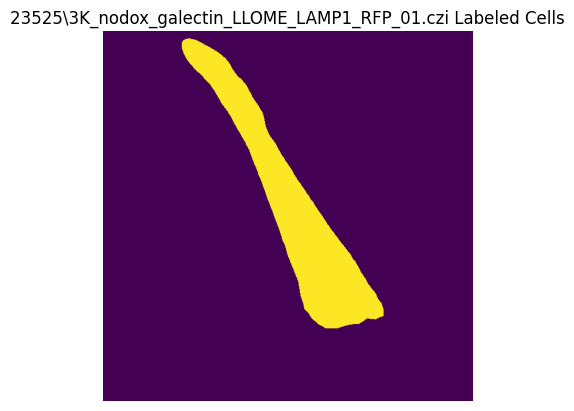

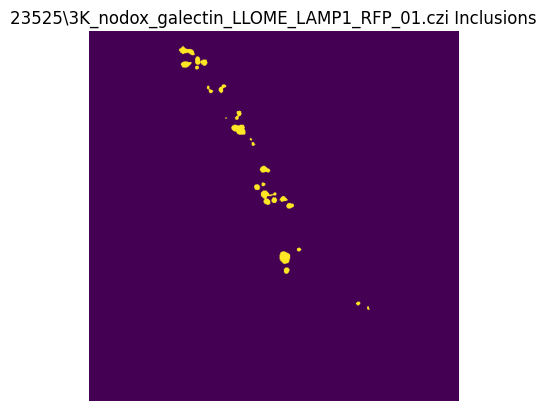

bleedthrough detected, using Otsu's threshold value


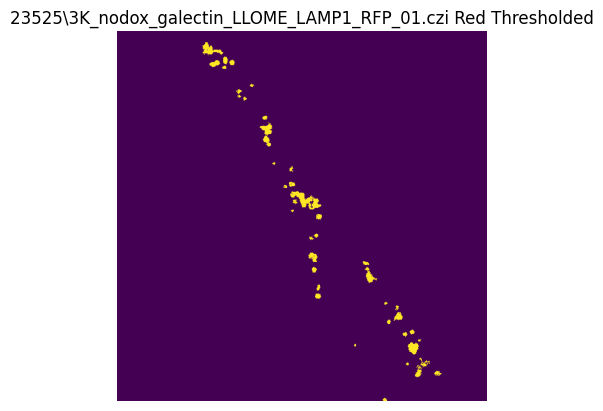

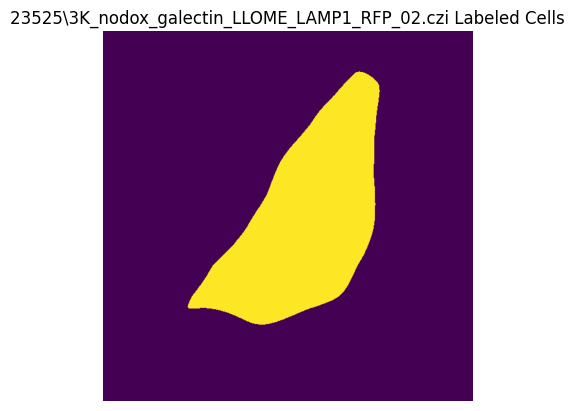

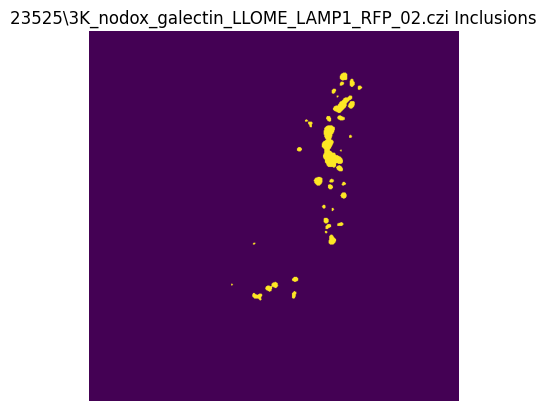

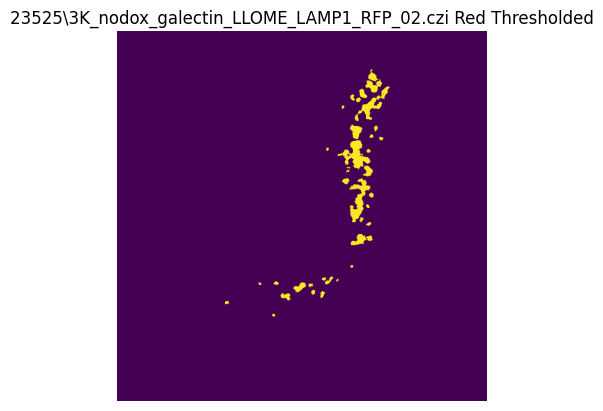

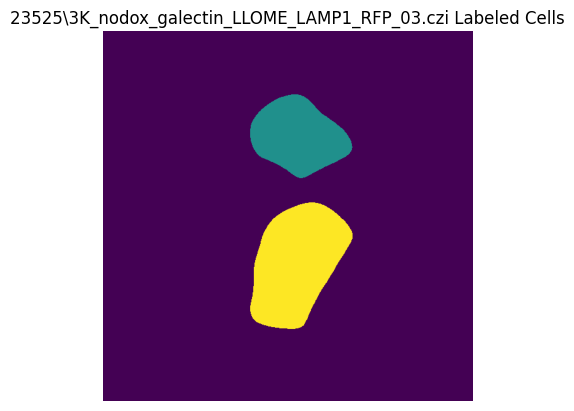

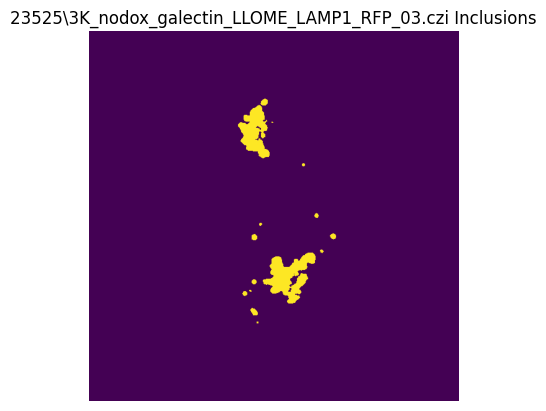

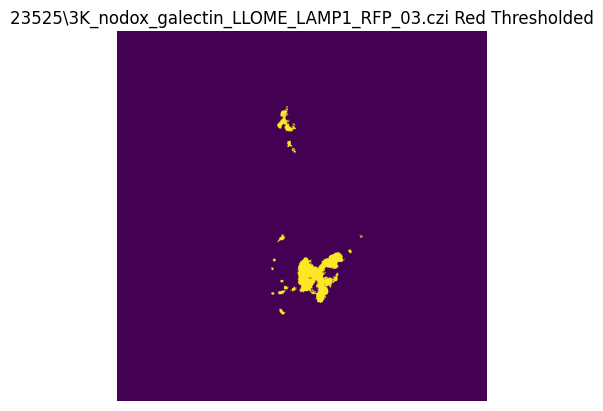

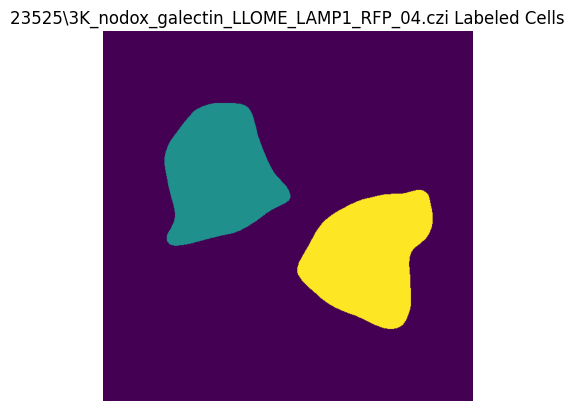

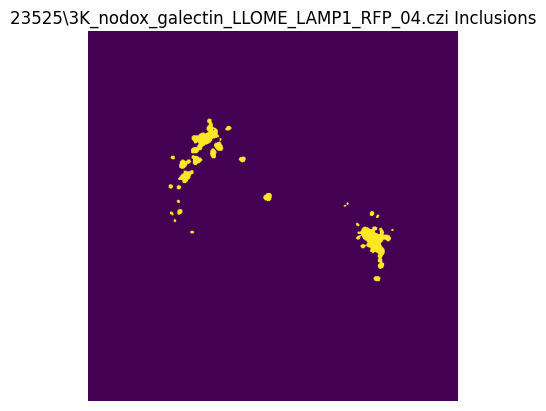

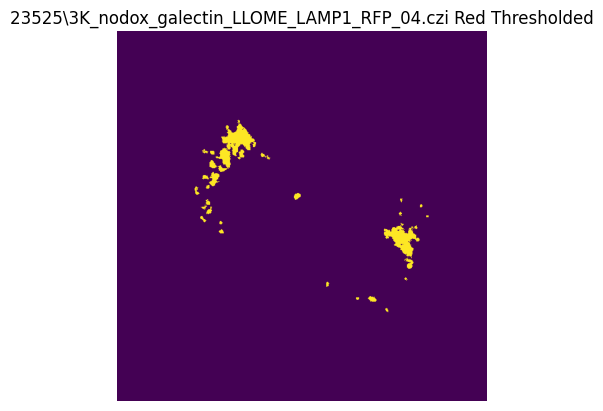

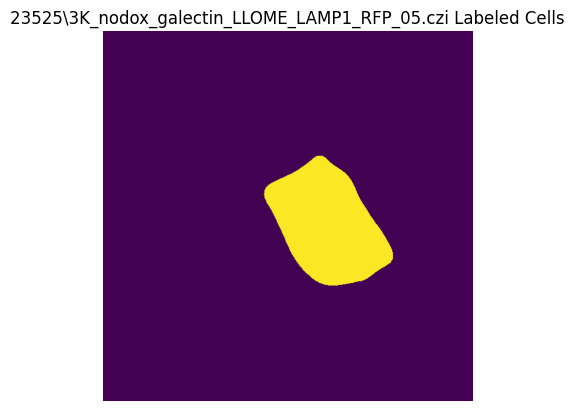

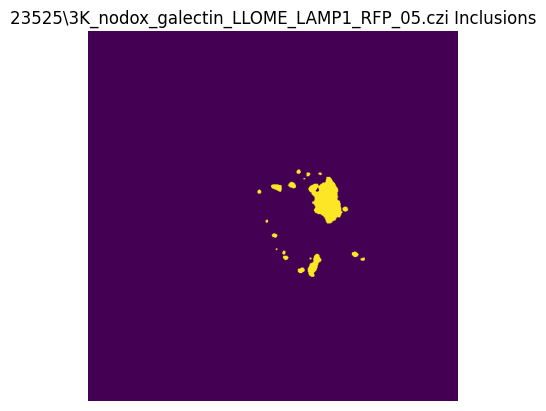

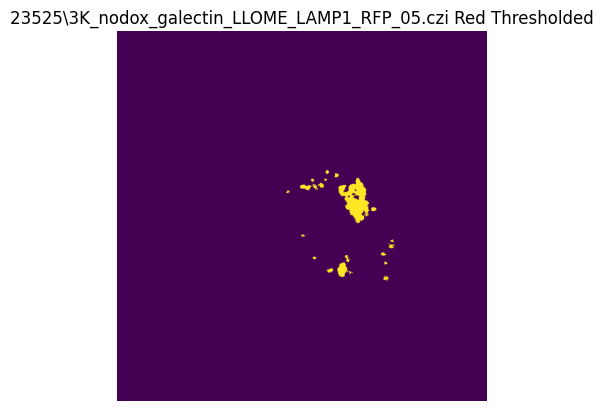

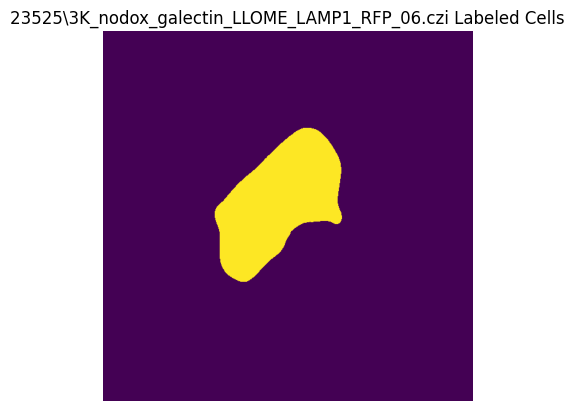

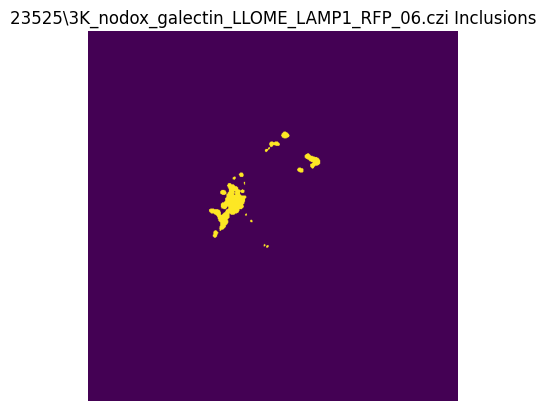

bleedthrough detected, using Otsu's threshold value


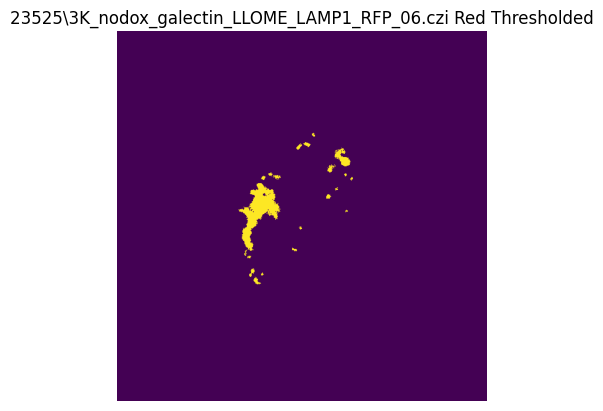

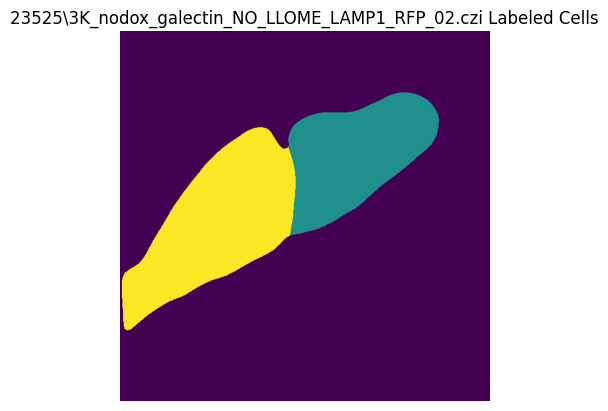

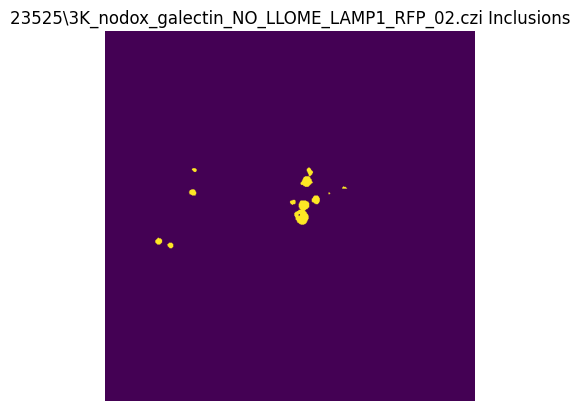

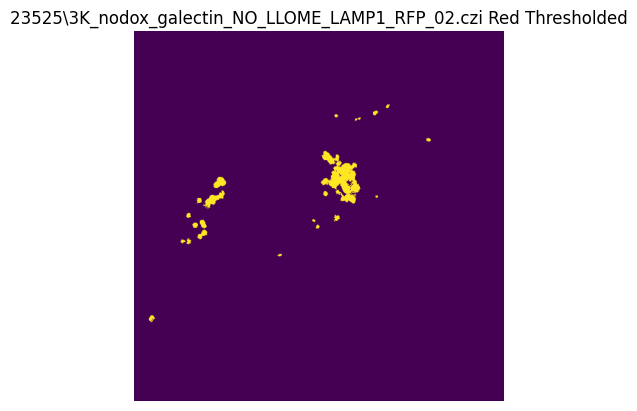

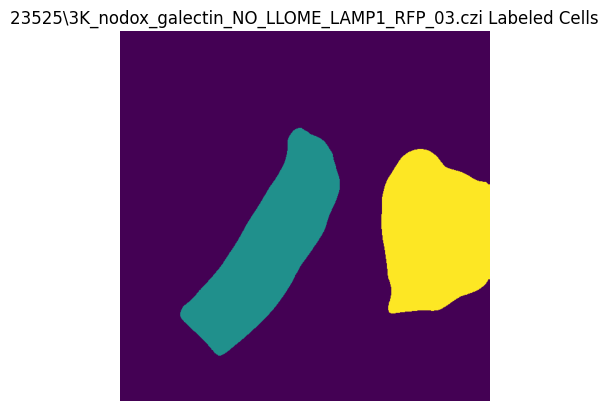

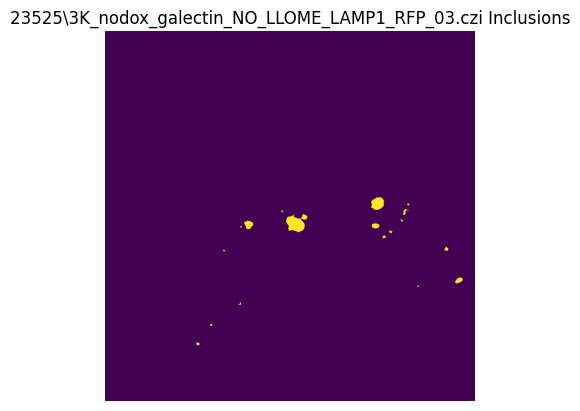

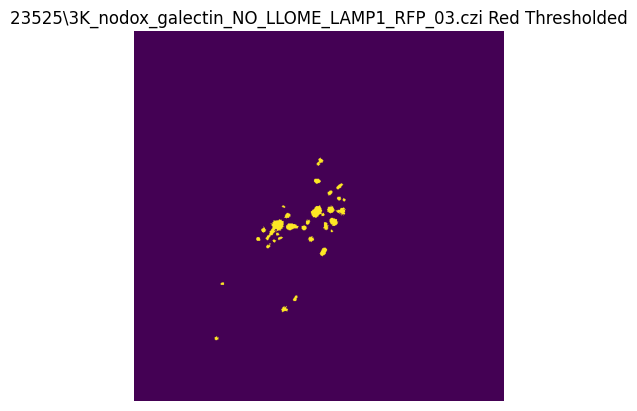

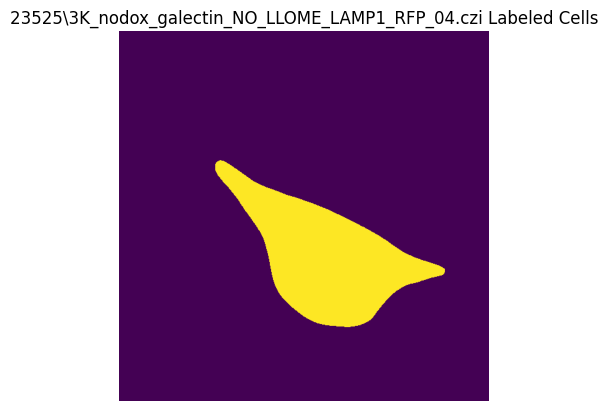

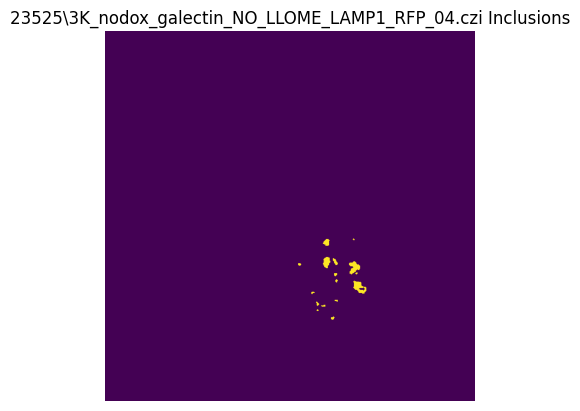

bleedthrough detected, using Otsu's threshold value


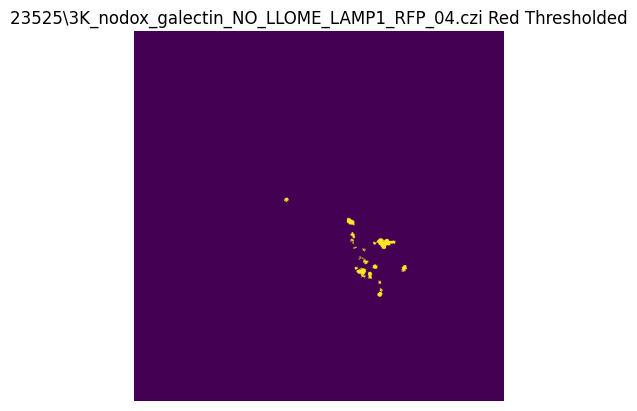

bleedthrough detected, using Otsu's threshold value


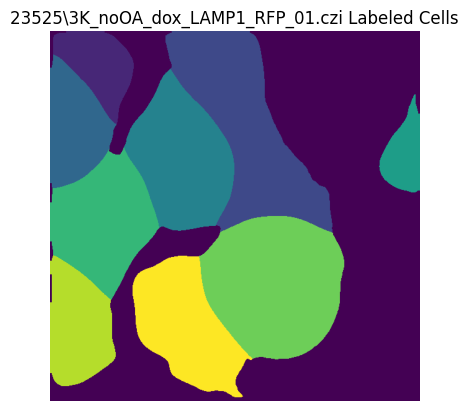

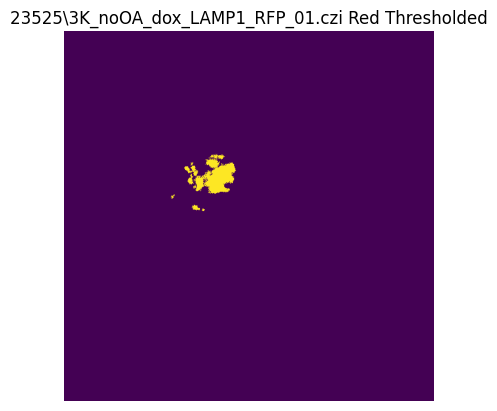

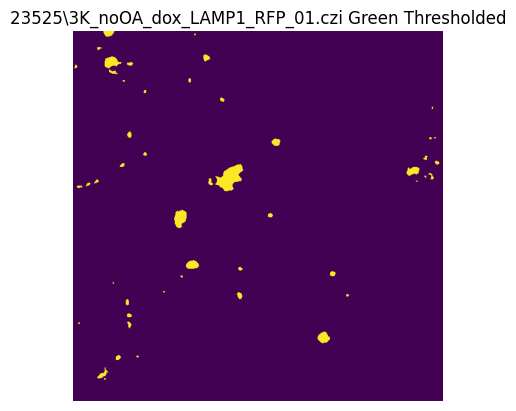

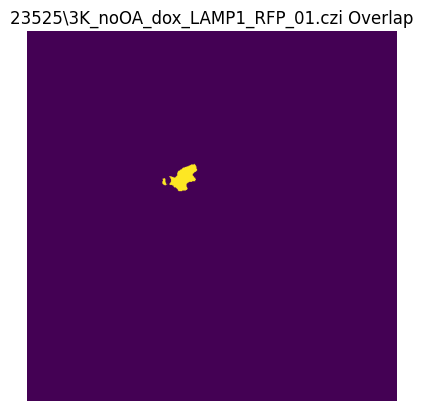

bleedthrough detected, using Otsu's threshold value


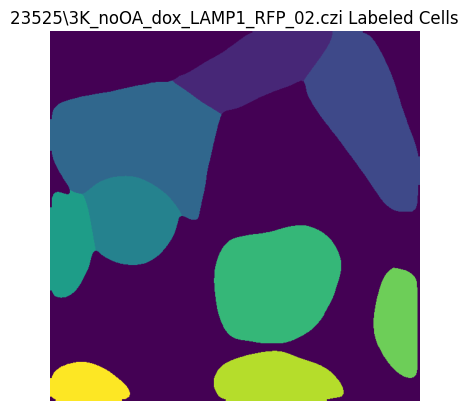

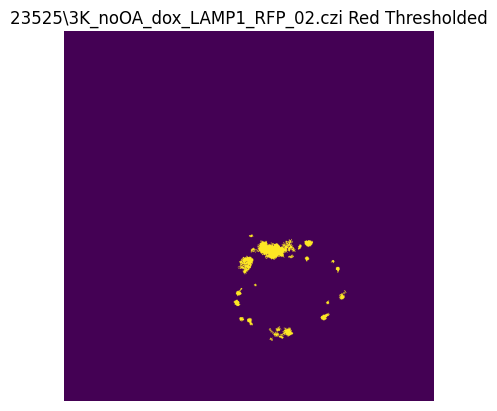

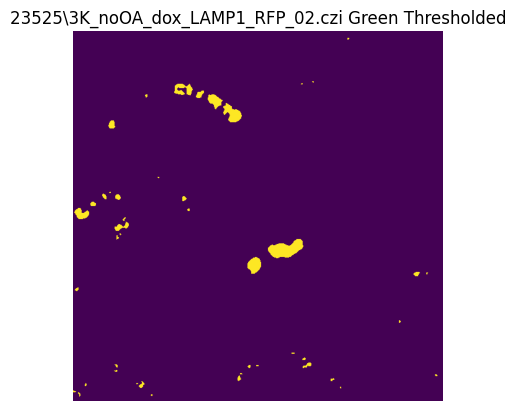

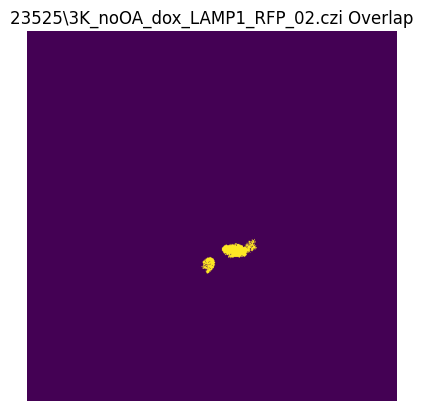

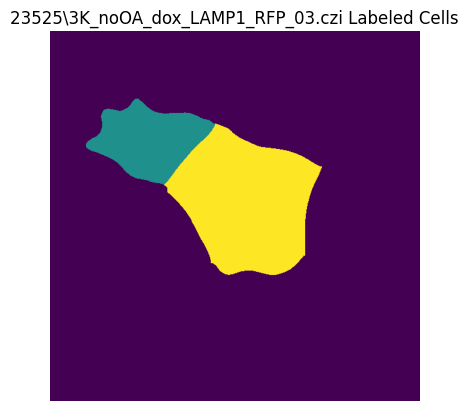

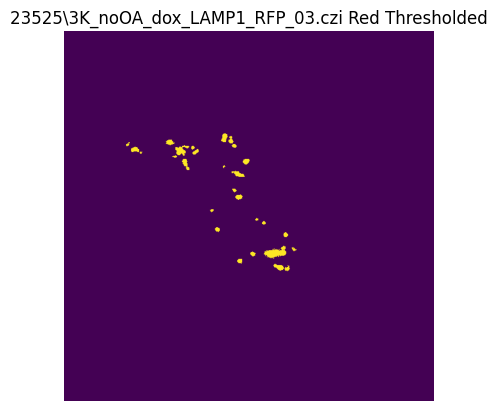

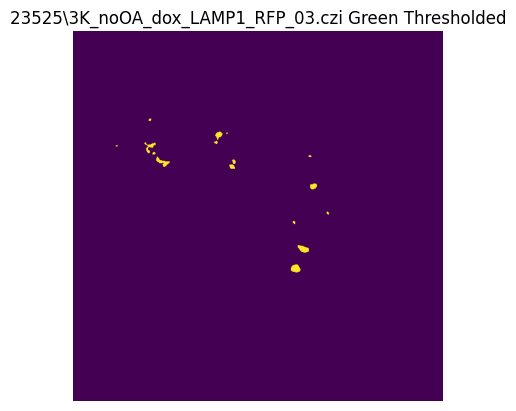

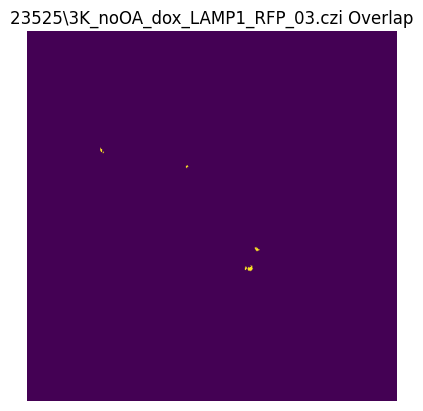

bleedthrough detected, using Otsu's threshold value


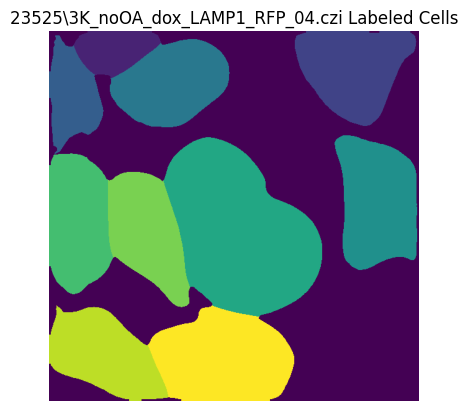

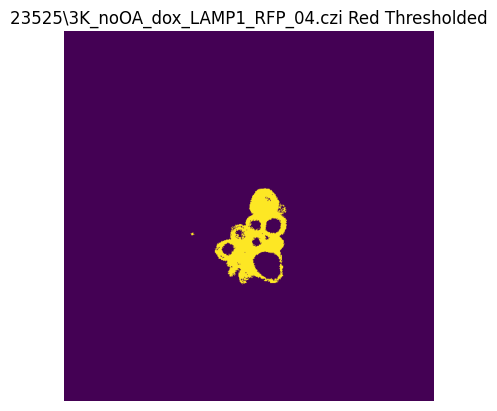

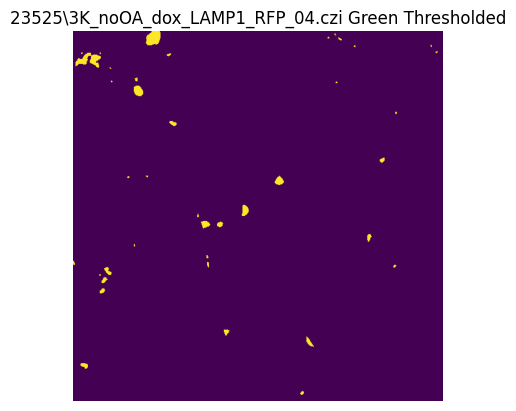

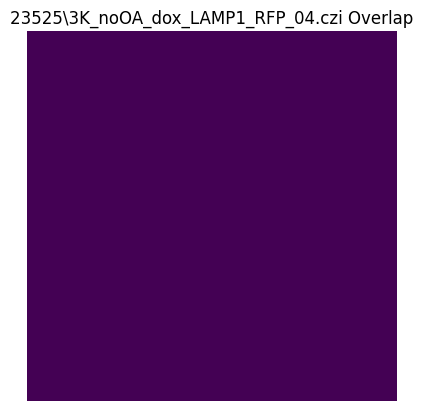

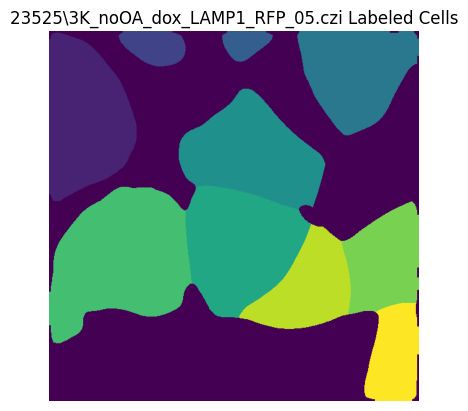

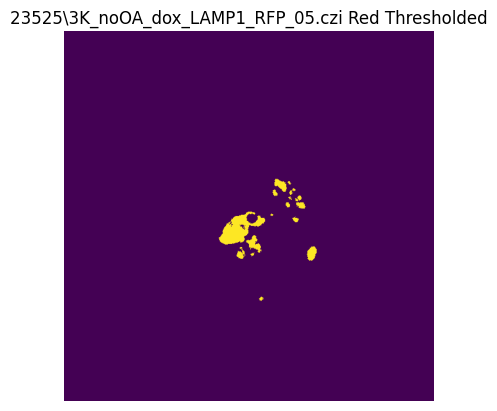

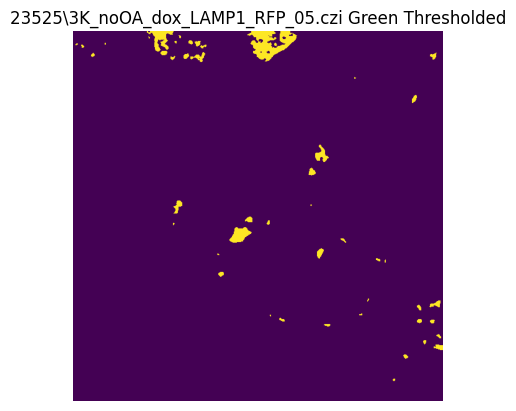

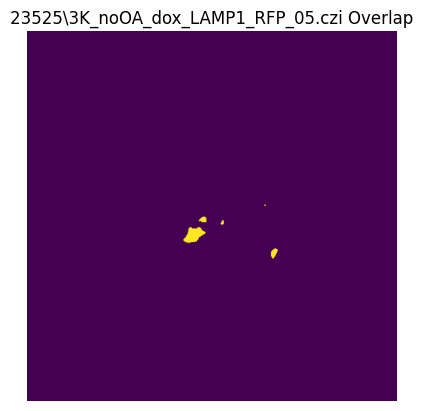

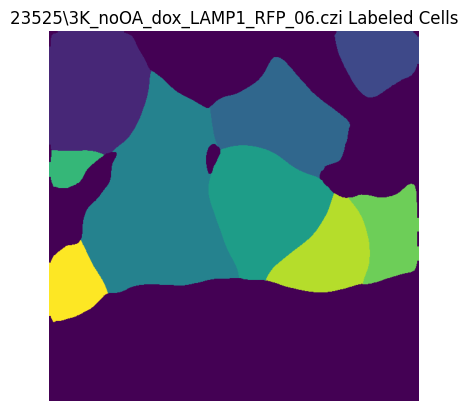

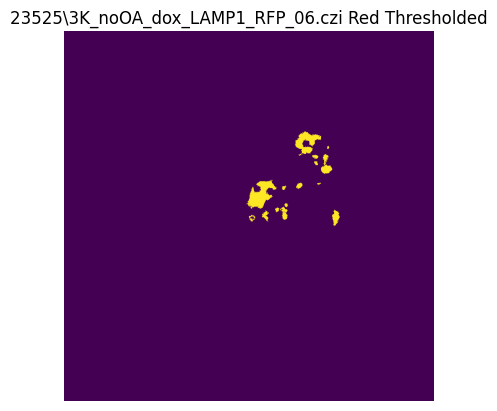

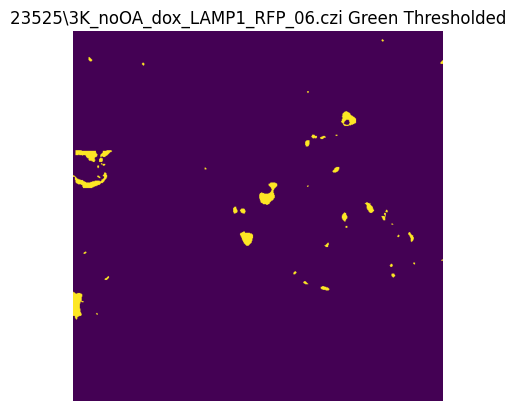

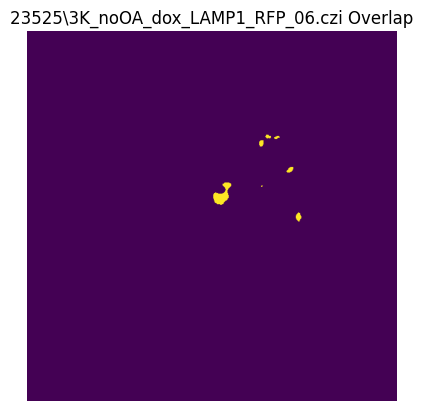

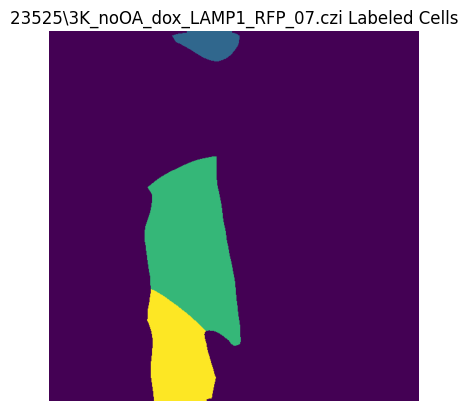

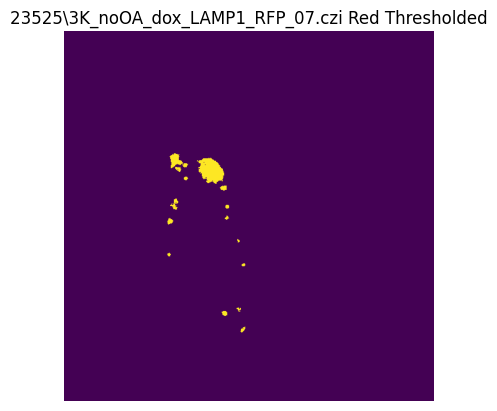

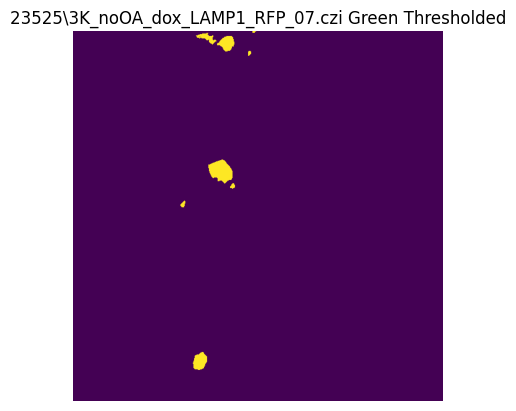

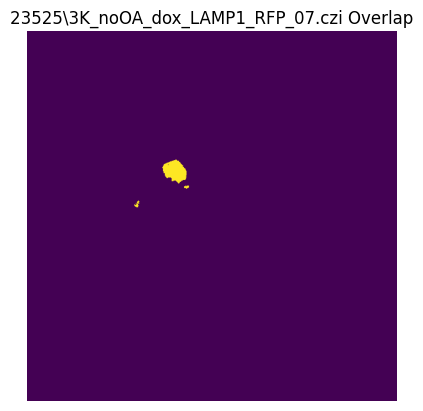

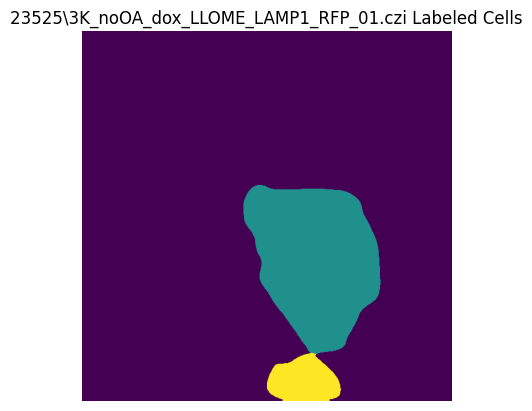

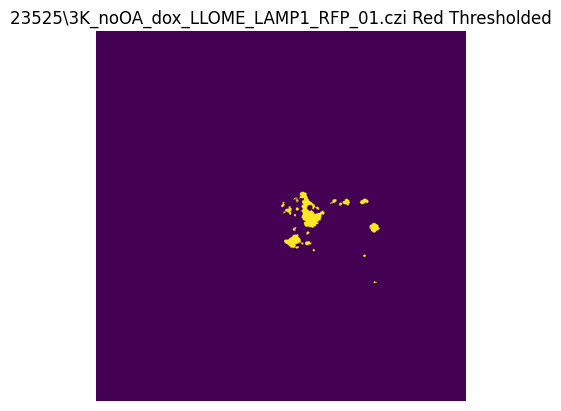

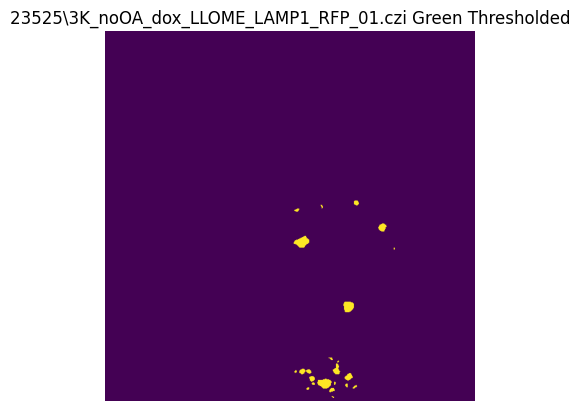

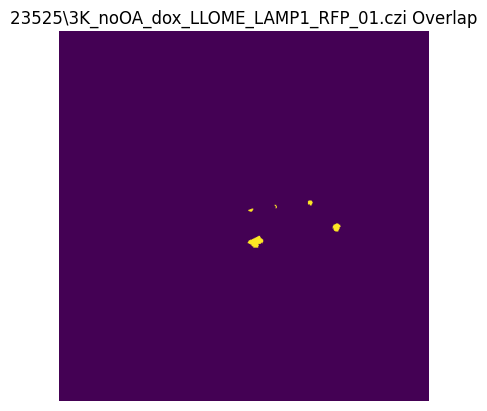

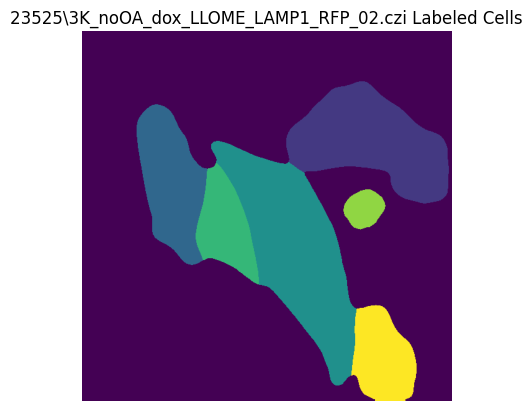

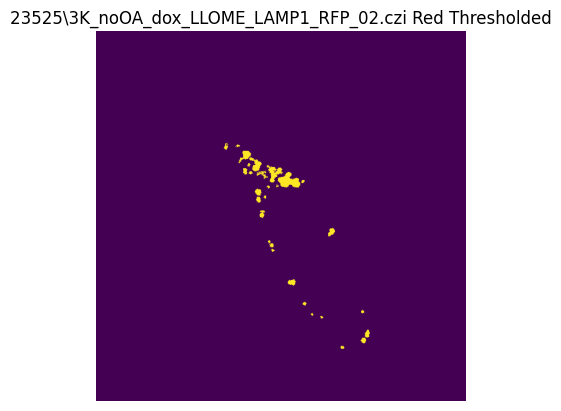

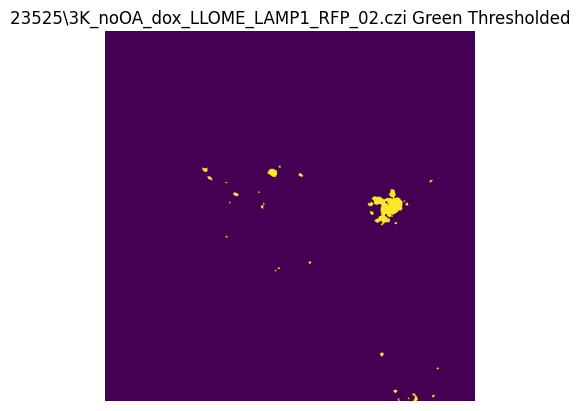

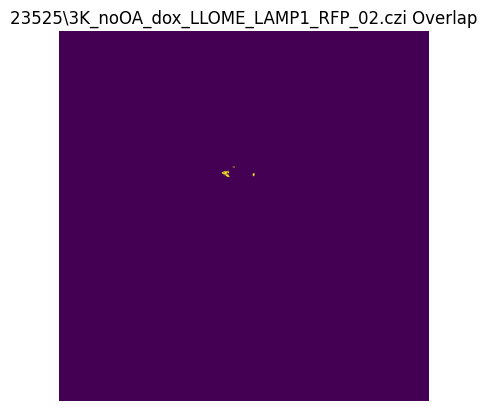

bleedthrough detected, using Otsu's threshold value


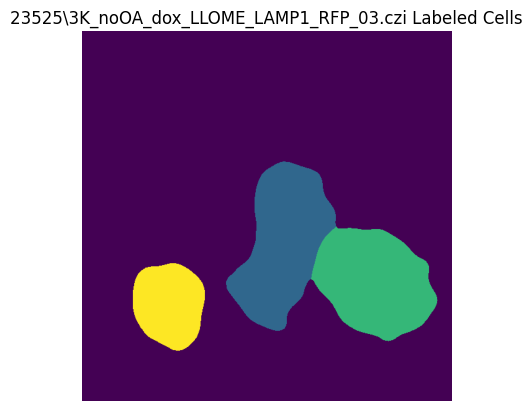

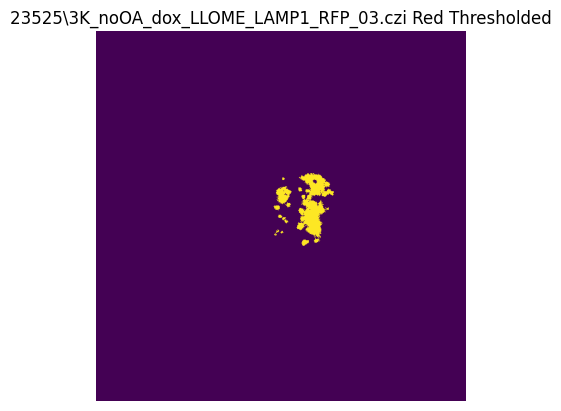

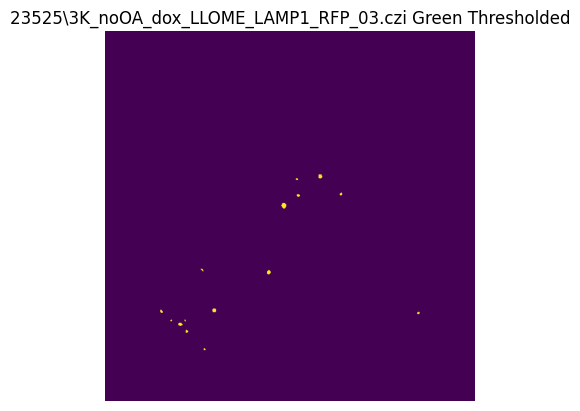

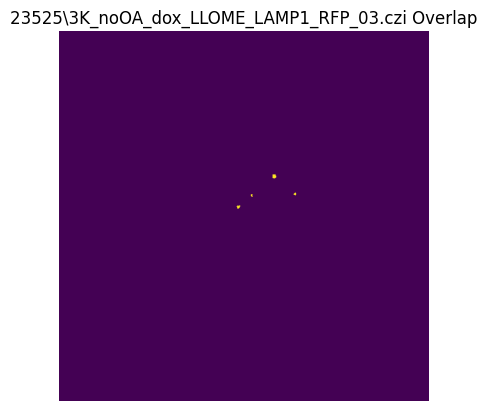

bleedthrough detected, using Otsu's threshold value


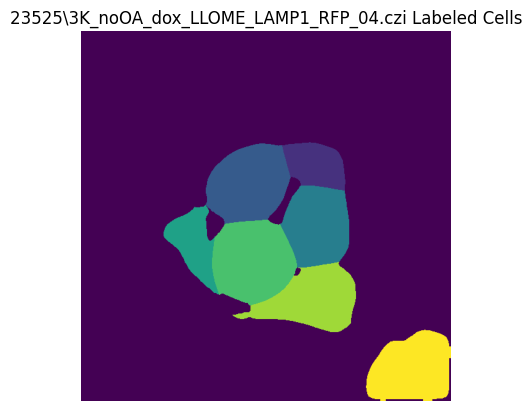

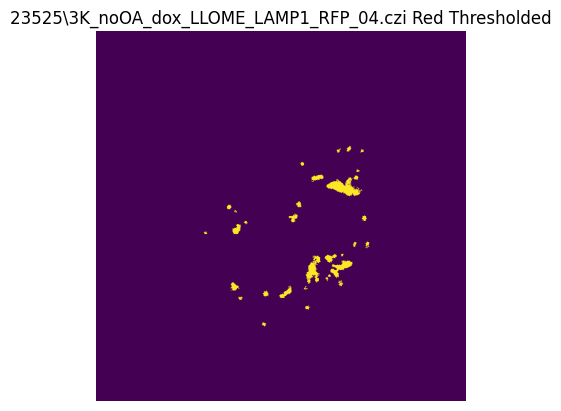

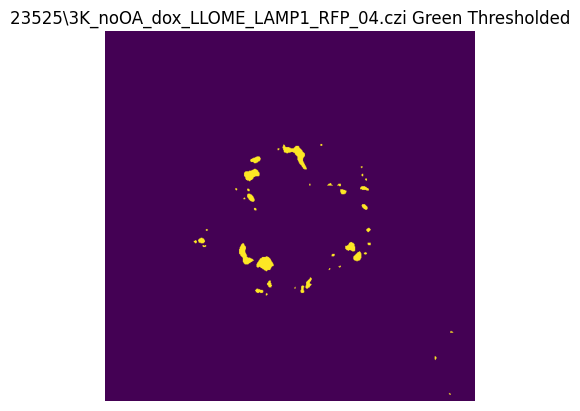

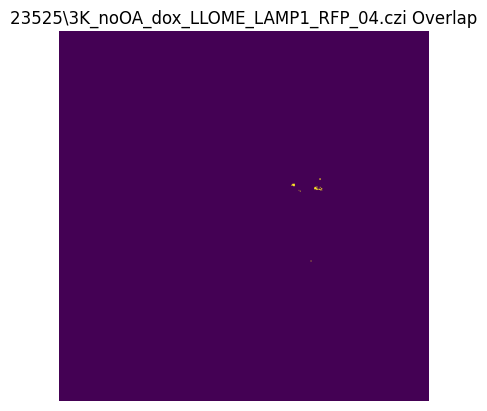

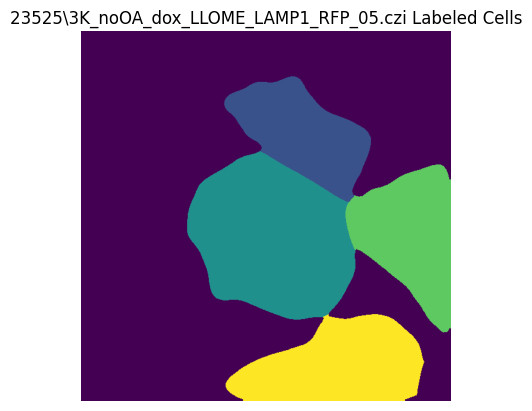

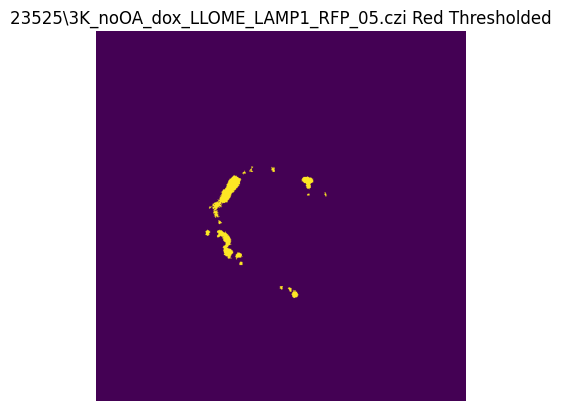

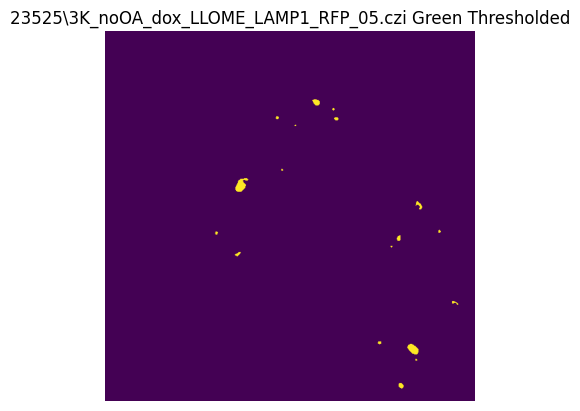

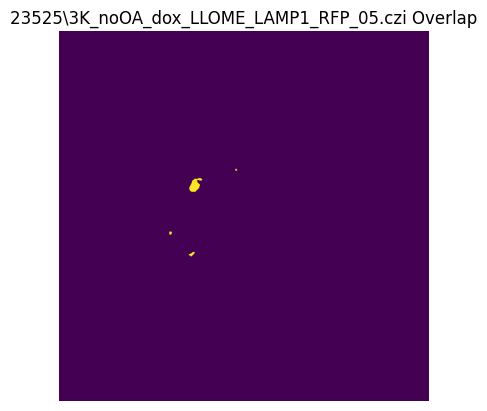

bleedthrough detected, using Otsu's threshold value


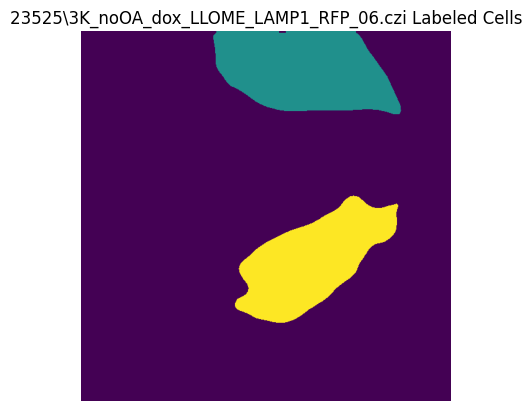

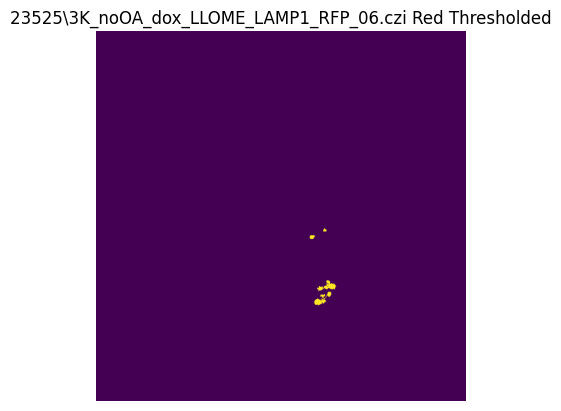

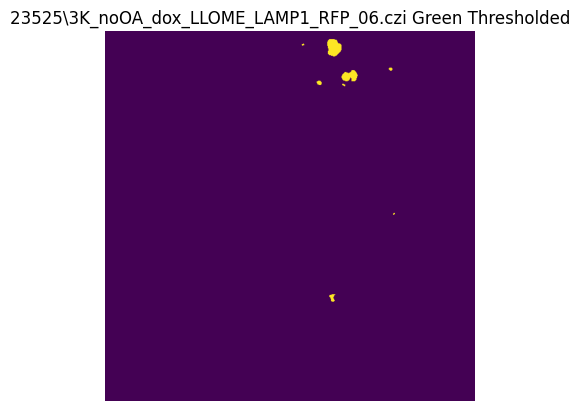

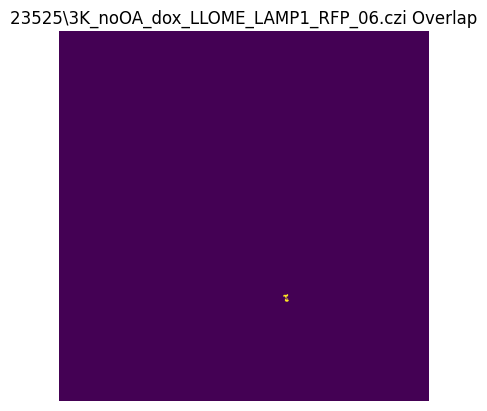

TypeError: Image data of dtype object cannot be converted to float

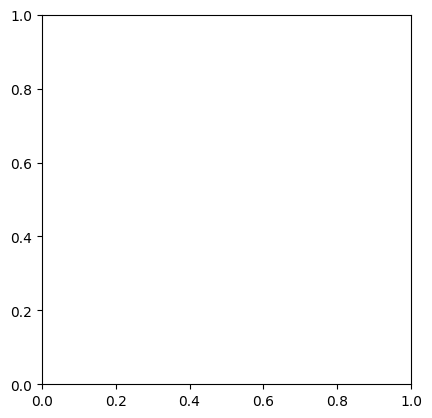

In [10]:
def main(image_folder):
    images_to_analyze = extract_image_paths(image_folder)
    output_dir = os.getcwd()

    df_summary = []
    df_inclusion_summary_total = []
    for path in images_to_analyze:
        image = read_image(path)
        image_squeezed = np.squeeze(image) 

        red, green = extract_channels(image_squeezed)
        if "nodox" in path:
            no_dox_analysis(red, green, path)
            #continue

        else: 
            df_cell_summary = dox_analysis(red, green, path)
            df_summary.append(df_cell_summary)
            #continue

    df_summary_combined_df = pd.concat(df_summary, ignore_index=True)
    output_df_summary_path = os.path.join(output_dir, '41125_galectin_experiment.xlsx')
    df_summary_combined_df.to_excel(output_df_summary_path, index=False)

    df_inclusion_summary_combined_df = pd.concat(df_inclusion_summary_total, ignore_index=True)
    output_df_inclusion_summary_path = os.path.join(output_dir, '41125_galectin_experiment_inclusions.xlsx')
    df_inclusion_summary_combined_df.to_excel(output_df_inclusion_summary_path, index=False)



if __name__ == "__main__":
    image_folder = '23525'
    main(image_folder)
